# Regression - Housing Price Prediction

In [3]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import lightgbm as lgb 
from sklearn import pipeline
from sklearn import model_selection 
from sklearn import metrics
from sklearn import preprocessing 
from sklearn import compose
from yellowbrick.regressor import *
from yellowbrick.classifier import * 
train = pd.read_csv('./data/train.csv').set_index('Id')
test = pd.read_csv('./data/test.csv').set_index('Id')

In [25]:
train.dtypes.value_counts()

object     43
int64      33
float64     4
dtype: int64

# Grab Column Dtypes

In [4]:
numeric_ = train.select_dtypes(['int','float']).columns
object_ = train.select_dtypes(['O']).columns
train['LogPrice'] = train['SalePrice'].apply(np.log1p)

# EDA

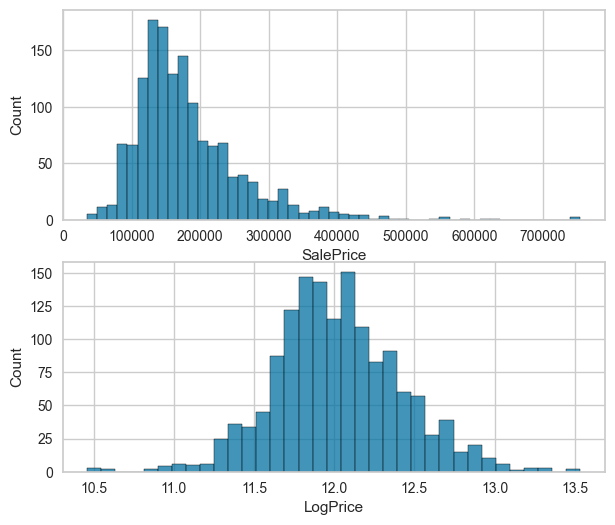

In [5]:
fig,axs=plt.subplots(2,1, figsize=(7,6))
sns.histplot(train['SalePrice'],ax=axs[0])
sns.histplot(train['LogPrice'], ax=axs[1])
train['SalePrice'] = train['LogPrice']
train.drop(columns=['LogPrice'],inplace=True)

# Data Transform Pipe

In [137]:
cat_transform = compose.ColumnTransformer(transformers=[
    ('ohe', preprocessing.OneHotEncoder(handle_unknown='ignore'), object_)]
                                          ,remainder='passthrough',verbose_feature_names_out=False)
m = lgb.LGBMRegressor()
pipe = pipeline.Pipeline(steps=[
            ('ohe',cat_transform),
            ('m', m)])

# Grid Search

In [143]:
X = pd.DataFrame(cat_transform.fit_transform(train).todense())
X.drop(columns=[304],inplace=True)

In [144]:
# X = train.drop(columns=['SalePrice'])
# y = train['SalePrice']
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=.3, random_state=0)

In [110]:
feats = {
    'num_leaves':[25, 31, 55, 100],
    'max_depth':[-1,0,1],
    'learning_rate':[.1, .2, .05],
    'n_estimators':[50,100, 130
}

In [111]:
clf = model_selection.GridSearchCV(lgb.LGBMRegressor(), feats)
clf.fit(X_train, y_train)

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.2, 0.05],
                         'max_depth': [-1, 0, 1],
                         'n_estimators': [50, 100, 130],
                         'num_leaves': [25, 31, 55, 100]})

In [112]:
clf.best_params_

{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 130, 'num_leaves': 25}

In [147]:
m = lgb.LGBMRegressor(**clf.best_params_)
m.fit(X_train,y_train)

LGBMRegressor(learning_rate=0.2, max_depth=1, n_estimators=130, num_leaves=25)

In [148]:
# cv = model_selection.KFold(n_splits=100, shuffle=True, random_state=1)
# scores = model_selection.cross_val_score(pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, verbose=1)
# abs(scores)
# print(f'Mean:{abs(scores.mean()):.2}')

[1]	training's l2: 0.135345	valid_0's l2: 0.127568
[2]	training's l2: 0.117815	valid_0's l2: 0.111027
[3]	training's l2: 0.104067	valid_0's l2: 0.0967605
[4]	training's l2: 0.0934798	valid_0's l2: 0.0850186
[5]	training's l2: 0.0842939	valid_0's l2: 0.0764949
[6]	training's l2: 0.0772133	valid_0's l2: 0.0690772
[7]	training's l2: 0.0708502	valid_0's l2: 0.0625538
[8]	training's l2: 0.065462	valid_0's l2: 0.057949
[9]	training's l2: 0.0610116	valid_0's l2: 0.0539026
[10]	training's l2: 0.0571647	valid_0's l2: 0.0513561
[11]	training's l2: 0.0537318	valid_0's l2: 0.0483318
[12]	training's l2: 0.0507294	valid_0's l2: 0.0455965
[13]	training's l2: 0.0480412	valid_0's l2: 0.0427023
[14]	training's l2: 0.0456758	valid_0's l2: 0.0403097
[15]	training's l2: 0.0434145	valid_0's l2: 0.0382535
[16]	training's l2: 0.0413709	valid_0's l2: 0.0365607
[17]	training's l2: 0.0395899	valid_0's l2: 0.0351554
[18]	training's l2: 0.0380388	valid_0's l2: 0.0339004
[19]	training's l2: 0.0365988	valid_0's l2: 

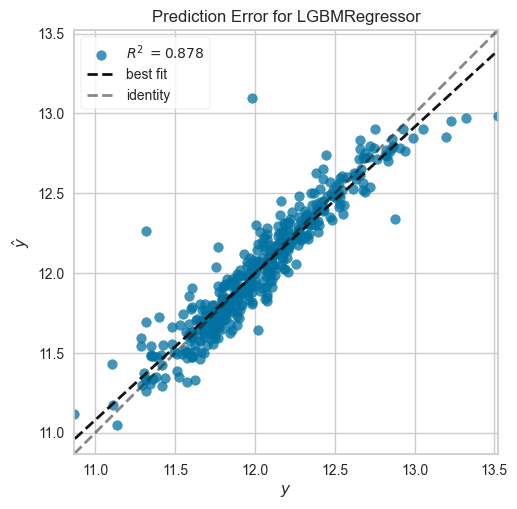

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

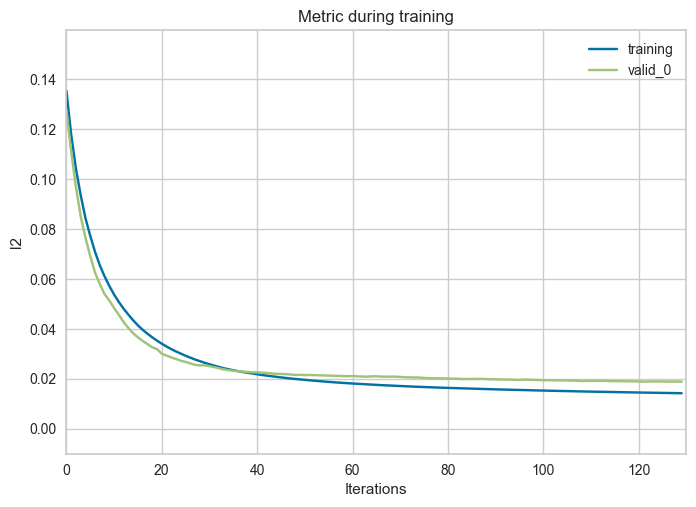

In [154]:
m = m.fit(X_train,y_train, eval_set=[(X_test,y_test),(X_train,y_train)]);
preds = np.exp(m.predict(X_test))
vis = PredictionError(m)
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()
lgb.plot_metric(m)

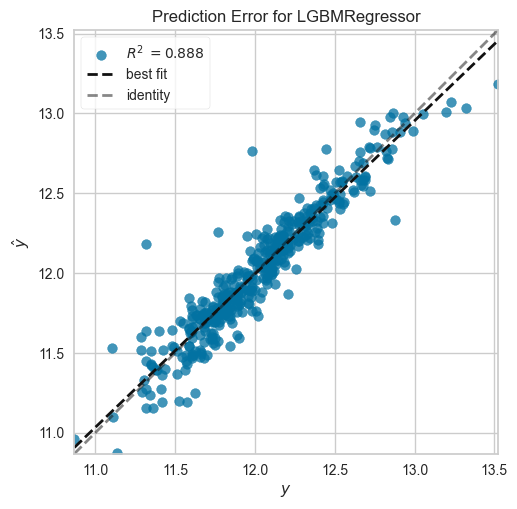

<AxesSubplot:title={'center':'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [142]:
m = pipe.fit(X_train,y_train)
preds = np.exp(m.predict(X_test))
vis = PredictionError(m)
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

In [138]:
m = pipe.fit(X,y)
preds = np.exp(m.predict(test))
test['SalePrice'] = preds
test['SalePrice'].to_csv("preds.csv")

# Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

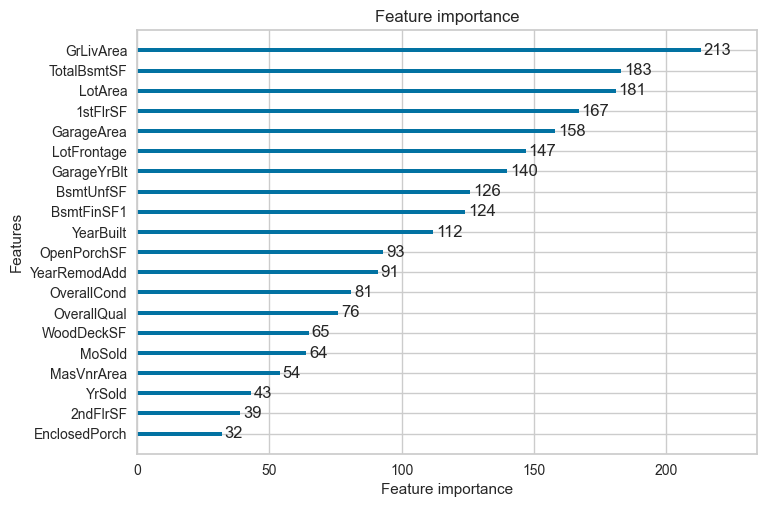

In [140]:
z = pd.DataFrame(cat_transform.fit_transform(X_train).todense(), 
            columns=cat_transform.get_feature_names_out())

m = lgb.LGBMRegressor()
m.fit(z, y_train)
lgb.plot_importance(m,max_num_features=20)

# Multi-Class Classifier

In [78]:
copy = train.copy()
copy['target'] = pd.qcut(x=copy['SalePrice'],q=4, precision=1)
mapping = dict(enumerate(copy['target'].cat.categories ) )
copy['target'] = copy['target'].cat.codes
X_train,X_test,y_train,y_test = model_selection.train_test_split(copy.drop(columns=['target','SalePrice']), copy['target'])

In [79]:
X_train = cat_transform.transform(X_train)
X_test = cat_transform.transform(X_test)

In [80]:
m = lgb.LGBMClassifier()
m.fit(X_train,y_train)
preds = m.predict(X_test)

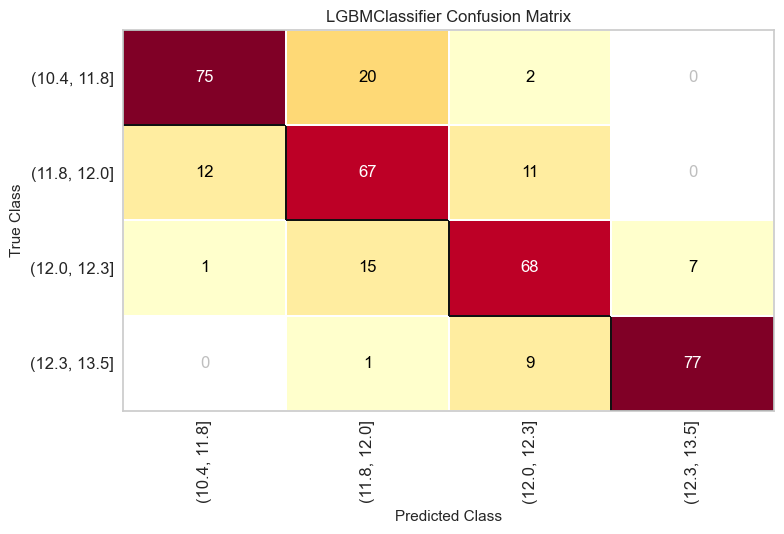

<AxesSubplot:title={'center':'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [81]:
c = [str(mapping[x]) for x in mapping.keys()]
vis = ConfusionMatrix(m, classes=c)
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

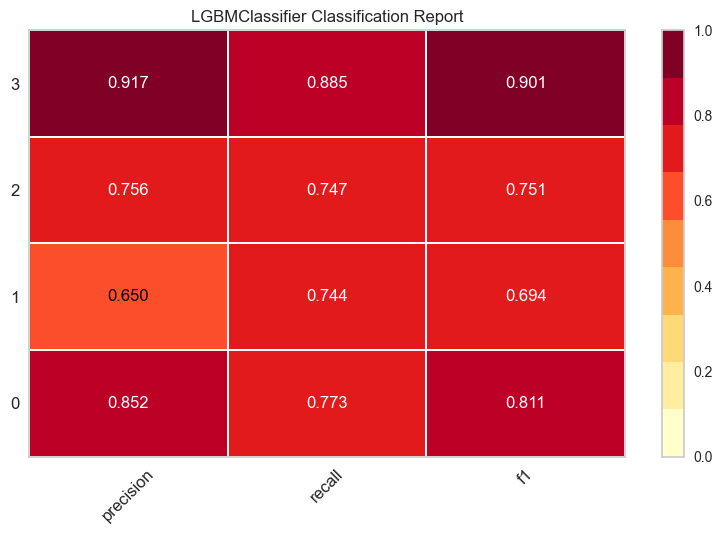

<AxesSubplot:title={'center':'LGBMClassifier Classification Report'}>

In [82]:
vis = ClassificationReport(m, classies=[0,1,2,3])
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

**CV**

In [83]:
p=pipeline.Pipeline(steps=[
    ('ohe',cat_transform),
    ('m', lgb.LGBMClassifier(**clf.best_params_))
])

In [84]:
X_train,X_test,y_train,y_test=model_selection.train_test_split(copy.drop(columns=['SalePrice','target']), copy['target'], test_size=.3)

- Micro for class imbalance. Since our classes are evenly distr. we will use macro.

In [85]:
cv = model_selection.KFold(n_splits=100, shuffle=True, random_state=1)
scores = model_selection.cross_val_score(p, X_train,y_train, scoring='f1_macro', cv=cv, verbose=1)
print(f'Mean:{abs(scores.mean())}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean:0.7012125420875421


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.7min finished
